In [14]:
#-------------------------Imports---------------------------
import numpy as np
#import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib
from mpl_toolkits import mplot3d
#import sympy as sy #symbolic algebra
import pandas as pd
from numpy.random import random

from scipy.stats import kstest
from scipy.stats import ks_2samp
from scipy.stats import uniform
from scipy import interpolate
from scipy.integrate import quad
from scipy.integrate import trapz
from scipy import constants

import os
#from astropy.cosmology import Planck15
from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.table import Table

from tqdm import tqdm
from multiprocessing import Pool
import time

###########################
# CONSTANTS
###########################
H0GLOB= 67#69.32#67.9 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
cosmoglob = Planck18
cosmofast = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)
H0=cosmoglob.H(0).value
h=H0GLOB/100
#geometrization of masses
Msun=(1.98892)*(10**30)
solarmass_to_m=(constants.G*Msun)/((constants.c)**2)#G/c^2
Mpc_to_m=3.08567758128*(10**22) #this will be used later
#-------miscellanea-----------------------
xmax=100
ymax=100
zmax=100
half_box_size=2

Npoints=1000
Sigma=10
#----------------from distances to redshift----------------------
zz=np.linspace(0,10,50000)
distinterpol=(1+zz)*cosmofast.comoving_distance(zz).value
z_of_dl=interpolate.interp1d(distinterpol,zz)
distinterpol_dc=cosmofast.comoving_distance(zz).value
z_of_dc=interpolate.interp1d(distinterpol_dc,zz)
#------------------------------------------------------------
print(cosmofast)

FlatLambdaCDM(H0=67.0 km / (Mpc s), Om0=0.319, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None)


In [2]:
#--------------------------definitions-------------------------
def NumOfDS(x,y,z):
    #this will evaluate the dN/dz
    r=np.sqrt(x**2+y**2+z**2)
    #numberofDS=1000/r
    numberofDS=2
    num=int(numberofDS)
    #print(num)
    if num>0:
        return num
    else:
        return 1
#-----------rejection-stuff------------
def sample(g,xmin,xmax):
    x = np.linspace(xmin,xmax,1000000)
    y = g(x)                        # probability density function, pdf
    cdf_y = np.cumsum(y)            # cumulative distribution function, cdf
    cdf_y = cdf_y/cdf_y.max()       # takes care of normalizing cdf to 1.0
    inverse_cdf = interpolate.interp1d(cdf_y,x,fill_value="extrapolate")# this is a function
    #inverse_cdf = np.interp(0,cdf_y,x) #this works but it is not a function
    return inverse_cdf
def return_samples(f,xmin,xmax,N=1000000):
    # let's generate some samples according to the chosen pdf, f(x)
    uniform_samples = random(int(N))       
    required_samples = sample(f,xmin,xmax)(uniform_samples)
    return required_samples
#--------------Placer-----------------------------
def DS_Maker(radii,perc,numHost,xhost,yhost,zhost):
    #the DSs are generated in a sphere, centered on the host. and the distance must follow
#the correlation distribution. 
#To generate points on a unit sphere see https://mathworld.wolfram.com/SpherePointPicking.html
# A python implementation https://stackoverflow.com/questions/5408276/sampling-uniformly-distributed-random-points-inside-a-spherical-volume
    #remember: you have to return also the indices of the hosts that have DSs
    x_Dark=[]
    y_Dark=[]
    z_Dark=[]
    phi_to_return=[]
    theta_to_return=[]
    r_to_return=[]
    full_r=[]
    
    arr_n=[]
    NDS=int(perc*numHost)
    indices=np.zeros(NDS)
    
    for k in range(NDS):
        i=np.random.randint(0, numHost-1)
        indices[k]=i
        dist_x=xhost[i]
        dist_y=yhost[i]
        dist_z=zhost[i]
        n=NumOfDS(dist_x,dist_y,dist_z)
        arr_n=np.append(arr_n,n)
        for d in range(n):
            phi =np.random.uniform(0,2*np.pi)
            costheta =np.random.uniform(-1,1)
            theta = np.arccos(costheta)
            r=np.random.choice(radii)
            full_r=np.append(full_r,r)
            if r>=distcut:
                x_DS = r * np.sin( theta) * np.cos( phi )
                y_DS = r * np.sin( theta) * np.sin( phi )
                z_DS = r * np.cos( theta )
                r_to_return=np.append(r_to_return,r)
            else:
                d=d-1

            #real values: do some check
            
            theta_to_return=np.append(theta_to_return,costheta)
            phi_to_return=np.append(phi_to_return,phi)
        
            x_Dark=np.append(x_Dark,dist_x+x_DS)
            y_Dark=np.append(y_Dark,dist_y+y_DS)
            z_Dark=np.append(z_Dark,dist_z+z_DS)
    #--------only unique indices of host-DS
    filtered=np.unique(indices.astype(int))
    return x_Dark, y_Dark, z_Dark, filtered, arr_n,r_to_return,theta_to_return,phi_to_return,full_r
def deg_to_rad(angle):
    ret=np.pi*angle/180
    return ret

In [3]:
#------------read the flagship-------------------------------------
dat = Table.read('11536.fits', format='fits')
df = dat.to_pandas()#all good, is an only text fits
print(df.columns)
print(df.shape)

Index(['ra_gal', 'dec_gal', 'observed_redshift_gal', 'true_redshift_gal',
       'x_gal', 'y_gal', 'z_gal', 'vx_gal', 'vy_gal', 'vz_gal'],
      dtype='object')
(14047533, 10)


In [4]:
print(df.ra_gal.min(),df.ra_gal.max())
print(df.dec_gal.min(),df.dec_gal.max())
print(df.ra_gal[0],df.dec_gal[0])

1.5581167e-05 89.99999
2.9646462e-06 89.98295
26.931496 48.581944


In [5]:
#distances are in Mpc/h and are comoving distances. We need luminosity distances and Mpc 
host_x=df['x_gal'].values/h #restore the right units
host_y=df['y_gal'].values/h
host_z=df['z_gal'].values/h
host_obs_redshift=df['true_redshift_gal'].values
#host_true_redshift=df['true_redshift_gal'].values
lum_host_x=host_x*(1+host_obs_redshift)
lum_host_y=host_y*(1+host_obs_redshift)
lum_host_z=host_z*(1+host_obs_redshift)
dl=np.sqrt(lum_host_x[-1]**2+lum_host_y[-1]**2+lum_host_z[-1]**2)
dc=np.sqrt(host_x[-1]**2+host_y[-1]**2+host_z[-1]**2)

#print(dc,dl,dl/dc-1,host_obs_redshift[-1],host_true_redshift[-1])

In [ ]:
print(dc,dl,dl/dc-1,host_obs_redshift[-1])

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()
num=int(df.shape[0]*0.0001)
ax.scatter(np.random.choice(lum_host_x,num), np.random.choice(lum_host_y,num),
           np.random.choice(lum_host_z,num), c = 'b', s = 5)
ax.set_title('Host-Dristibution')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)
#plt.savefig('HostDist.pdf')
ax.view_init(60, 65)#rotation along x z
figtot2dxy = plt.figure(figsize = (10,10))
ax = plt.axes()
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(linestyle='dotted', linewidth='0.6')
ax.scatter(np.random.choice(lum_host_x,num), np.random.choice(lum_host_y,num),
           c = 'b', marker="*", label='Host')
plt.legend(loc='upper left');

In [ ]:
#----------------MC-rejection-with-CDF----------------------
r0=5*h
gamma=0.2
#rmin=0.1*h
rmin=0
distcut=0.1*h
rmax=10*h
#target function
target_dist= lambda r: (r/r0)**(gamma)
#x = sy.Symbol('x')
#norm=sy.integrate(target_dist(x), (x, rmin, rmax))
#print(norm)
values=return_samples(target_dist,rmin,rmax,1000000)
real_values=values[values>=distcut]
shift=len(values)-len(real_values)
#np.savetxt('two_point_radii.txt',values)
#np.savetxt('two_point_radii_cutted.txt',real_values)

In [ ]:
print(len(real_values))
fast_shift=1-len(real_values)/len(values)
print(1-len(real_values)/len(values))

In [ ]:
Nhost=df.shape[0]
x_Dark, y_Dark, z_Dark, filtered,arr_n,real_r,real_theta,real_phi,full_r=DS_Maker(values,0.001,Nhost,host_x,host_y,host_z)
print(len(x_Dark))

In [ ]:
fig2 = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()

ax.scatter(x_Dark, y_Dark, z_Dark, c = 'g', s = 10)
ax.set_title('DS-Dristibution')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)
#plt.savefig('DSDist.pdf')

In [ ]:
figtot = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()
ax1 = figtot.add_subplot(111,projection='3d')

ax1.scatter(np.take(host_x,filtered), np.take(host_y,filtered),np.take(host_z,filtered), c = 'b', marker="*", label='Host')
ax1.scatter(x_Dark, y_Dark, z_Dark, s=5, c = 'g', marker="o", label='DS')
plt.legend(loc='upper left');
#plt.savefig('DS_and_Host.pdf')

In [ ]:
figtot2dxy = plt.figure(figsize = (10,10))
ax = plt.axes()
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(linestyle='dotted', linewidth='0.6')
ax.scatter(np.take(host_x,filtered), np.take(host_y,filtered), c = 'b', marker="*", label='Host')
ax.scatter(x_Dark, y_Dark, s=5, c = 'g', marker="o", label='DS')
plt.legend(loc='upper left');
#plt.savefig('DS_and_Host_xy.pdf')

In [ ]:
'''
Some checks on what we have so far
'''

In [ ]:
#--------------------host redshift distribution------------------------------------
n, bins, patches = plt.hist(x=host_obs_redshift, bins='auto', color='b',
                            alpha=0.7, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Redshift')
plt.ylabel('Frequency')
plt.title('N(z)')
maxfreq = n.max()
plt.yscale('log')
plt.xscale('log')
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [ ]:
## plot of the rejection results

x = np.linspace(0.1*h,rmax,1000000)
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')
ax.set_ylabel('probability density')
ax.plot(x,target_dist(x)/np.sum(target_dist(x)*(x[1]-x[0])) )
#ax.plot(x,target_dist(x)/norm ) #slow
ax.hist(values,bins='auto',density=True,range=(x.min(),x.max()))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mpc/h')
plt.ylabel('Frequency')
plt.yscale('log')
plt.xscale('log')
plt.title('Two-points correlation')
plt.show() 

In [ ]:
#---------------Distribution of phi------------------
count, bins, ignored = plt.hist(real_phi, 100, density=True)
line=np.ones_like(bins)
line=line/(2*np.pi)
plt.plot(bins, line, linewidth=2, color='r')
plt.show()

In [ ]:
#---------------Distribution of cos(theta)------------------
count, bins, ignored = plt.hist(real_theta, 100, density=True)#real_theta is cos(theta)
line=np.ones_like(bins)
line=line/(2)
plt.plot(bins, line, linewidth=2, color='r')
plt.show()

In [ ]:

Npoints=100
esp=1
phi =np.random.uniform(0,2*np.pi,Npoints)
costheta =np.random.uniform(-1,1,Npoints)
theta = np.arccos(costheta)
r=np.random.choice(values,Npoints)
wire_phi = np.linspace(0, np.pi, 20)
wire_theta = np.linspace(0, 2 * np.pi, 40)
x_sph = r * np.sin( theta) * np.cos( phi )
y_sph = r * np.sin( theta) * np.sin( phi )
z_sph = r * np.cos( theta )
x = rmin*np.outer(np.sin(wire_theta), np.cos(wire_phi))# outer product i.e. line*row
y = rmin*np.outer(np.sin(wire_theta), np.sin(wire_phi))
z = rmin*np.outer(np.cos(wire_theta), np.ones_like(wire_phi))
x_out = rmax*np.outer(np.sin(wire_theta), np.cos(wire_phi))# outer product i.e. line*row
y_out = rmax*np.outer(np.sin(wire_theta), np.sin(wire_phi))
z_out = rmax*np.outer(np.cos(wire_theta), np.ones_like(wire_phi))
fig, ax = plt.subplots(1, 1,subplot_kw={'projection':'3d'})
fig.set_size_inches(11.5, 11.5)
ax.scatter(x_sph, y_sph , z_sph, s=20, c='k', zorder=10)
ax.scatter(0, 0 , 0, s=100, c='r', zorder=10)
#ax.plot_wireframe(x, y, z, color='b', rstride=1, cstride=1)
ax.plot_wireframe(x_out, y_out, z_out, color='g', rstride=1, cstride=1)

ax.view_init(60, 65)#rotation along x z

In [ ]:
#---------- Test using real DS data------------------------------


In [ ]:
bins = 100
counts_cdf = []
counts_new_cdf = []
r_right=[]
#r=np.random.choice(values,70000)
step = real_r.max()/bins
R_min = distcut
#new_values=values[values>=R_min]

for myi in range(bins):
    right = R_min + (myi+0)*step
    bools_old = full_r<=right
    bools_new = real_r<=right
    
    counts_cdf = np.append(counts_cdf, len(full_r[bools_old]))
    counts_new_cdf = np.append(counts_new_cdf, len(real_r[bools_new]))
    
    r_right = np.append(r_right, right)
    
    #print(counts_cdf[myi],counts_new_cdf[myi])
    #print(counts_cdf[myi]-counts_new_cdf[myi])
shift=counts_cdf[0]-counts_new_cdf[0]
#shift=0.004*len(real_r)
#shift=fast_shift*len(real_r)
counts_cdf=counts_cdf/counts_cdf.max()
counts_new_cdf=counts_new_cdf+shift
counts_new_cdf=counts_new_cdf/counts_new_cdf.max()

    
    

In [ ]:
x = np.linspace(R_min,rmax,1000000)
zeta=1.2#gamma+1
norm=(rmax**(zeta))/((zeta)*r0**gamma)
print('CDF normalization {}\t Prefactor {}'.format(norm,1/norm))
handmade_cdf=lambda x: (x**(zeta))/(rmax**(zeta))


fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')

#ax.set_ylabel('probability density')

ax.plot(x,handmade_cdf(x) ,color='g')
plt.axvline(x=distcut)
ax.scatter(r_right, counts_new_cdf , s=50, marker='+', c='r', zorder=10)
ax.scatter(r_right, counts_cdf , s=20,marker='*', c='k', zorder=10)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mpc/h')
#plt.yscale('log')
#plt.xscale('log')
#plt.savefig('DS_cumulative.pdf')

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')

#ax.set_ylabel('probability density')

#ax.plot(x,handmade_cdf(x) ,color='g')
#plt.axvline(x=rmin)
ax.scatter(r_right, counts_cdf-counts_new_cdf , s=10,marker='x', c='r', zorder=10)#diff between full dist and dist with r_cut
ax.scatter(r_right, handmade_cdf(r_right)-counts_new_cdf , s=10,marker='x', c='g', zorder=10)#diff between cumulative and dist with r_cut
plt.axhline(y=0, color='k', linestyle='-')
#plt.ylim(bottom=-0.001,top=0.001)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mpc/h')
#plt.yscale('log')
#plt.xscale('log')
#plt.savefig('DS_cumulative.pdf')

In [ ]:
bins = 100
freq_r = []
r_center=[]
step = real_r.max()/bins
R_min = distcut
left=R_min
for myi in range(bins-1):
    right = left+ (myi+1)*step
    bools_left = left<real_r
    bools_right=real_r<=right
    bools_new= bools_left&bools_right
    #print(bools_left,bools_right,bools_new)
    freq_r = np.append(freq_r, len(real_r[bools_new]))
    
    r_center = np.append(r_center, left+step/2)
    left=right

In [ ]:
count= plt.hist(real_r, 100)#real_theta is cos(theta)

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')

xx=count[1]
xx=xx[:-1]
yy=count[0]
print(np.all(yy>20))
yy_err=np.sqrt(yy)/yy.sum()
yy=yy/yy.sum()

arr_teo=target_dist(xx)
arr_teo=arr_teo/arr_teo.sum()
res=yy-arr_teo
res2=(yy-arr_teo)/yy_err
ax.scatter(xx,res , s=10,marker='x', c='b', zorder=10)
plt.axhline(y=0, color='k', linestyle='-')
plt.errorbar(xx, res, yerr=yy_err, fmt="+")

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mpc/h')
#plt.yscale('log')
#plt.xscale('log')



In [ ]:

fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')
ax.scatter(xx,res2 , s=10,marker='x', c='k', zorder=10)
ax.fill_between(xx,1,-1,alpha=0.55, color='palegreen')

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mpc/h')
plt.ylabel('Distance in sigma')
#plt.yscale('log')
#plt.xscale('log')


In [ ]:
#--------------------SDSS like-------------------------
num_of_gal=np.array([1300,1300,500,800,800,1500,650,100,20,10])#Number of hosts in each z bin. 
sdss_bins=np.linspace(0,1,11)#bin Width 
#---------------Angular part--------------------------------
#we need to cover only 30 squared degrees of sky. phi = U(0,phi_lim) cos_theta=U(1,cos_lim)
#1 sq.deg.=(np.pi/180)**2 sr 

In [ ]:
alpha=30*(np.pi/180)**2
phi_lim=(2*np.pi-alpha/2)/24#In this way phi_lim ~ theta_lim 
theta_lim=np.arccos(1-alpha/phi_lim)
#print(phi_lim,theta_lim)
all_phi=np.random.uniform(0,phi_lim,500000)
all_cos=np.random.uniform(1,1-alpha/phi_lim,500000)
print(phi_lim,theta_lim)

In [6]:
#--------------------GW--Rate-----------------------------------------
#We will compute the gw rate from sratch 
#--------Star Formation Rate-------------------------------
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
th=1000/cosmofast.H(0).value
alpha=14/th
def psi(x):
    ret= 0.015*(((1+x)**(2.7))/(1+(((1+x)/(2.9))**(5.6))))
    return ret
#-------------Phi----------------------------
#phi=lambda x:(1/((1+x)*(cosmofast.H(x).value)))
def phi(x):
    #N=14/((1/((1+0)*(cosmoglob.H(0).value))))
    #ret=N*(1/((1+x)*(cosmoglob.H(x).value)))
    ret=(1000/((1+x)*(cosmofast.H(x).value)))
    return ret
#--------------time inversion-------------------------
def inverted_time(x):
    #is the lookback_time use astropy
    ret=cosmofast.age(0).value-cosmofast.age(x).value
    return ret
#----------------Decay--------------------------------
def decay(x,z,tau):
    ret=np.exp(-((cosmofast.lookback_time(x).value-cosmofast.lookback_time(z).value)/(tau)))
    return ret
#--------------time difference-------------------------
def inversetimediff(x,z,tmin):
    timediff=alpha*(cosmofast.age(z).value-cosmofast.age(x).value)
    num=np.heaviside((alpha*cosmofast.age(z).value-alpha*cosmofast.age(x).value) -tmin,0.5)
    res=(num)/timediff
    return res
#-------------------Deriv of Comoving Volume-------------
def DvolDz(x):
    prefactor=4*np.pi*(((clight)/(cosmofast.H(0).value))**3)#Mpc^3
    dist=quad((cosmofast.inv_efunc),0,x)[0]
    ret=prefactor*cosmofast.inv_efunc(x)*(dist**2)
    return ret
#def DeltavolDz(x_min,x_max):
#    prefactor=4*np.pi*(((clight)/(cosmofast.H(0).value))**3)#Mpc^3
#    dist=quad((cosmofast.inv_efunc),0,x)[0]
#    ret=prefactor*cosmofast.inv_efunc(x)*(dist**2)
#    return ret
def astrodiffvol(x):
    ret=cosmofast.differential_comoving_volume(x).value
    return ret

#------------------integrands------------------------------
def integrand_suvo(x,z,tmin):
    ret=psi(x)*(phi(x))*inversetimediff(x,z,tmin)/(1+z)
    return ret
def integrand_marr(x,z,tau):
    ret=psi(x)*(phi(x))*decay(x,z,tau)
    return ret
def totalrate(z,tmin):
    norm=50/(quad(integrand_marr,0,150,args=(0,tmin))[0]/tmin)
    littlerate=norm*quad(integrand_marr,z,150,args=(z,tmin))[0]/tmin
    ret=(littlerate*DvolDz(z))/(1+z)
    return ret
def Multy_Marra(zz):
    z=zz
    ret=Normaliz*(quad(integrand_marr,z,100,args=(z,tpar))[0]/tpar)
    return ret

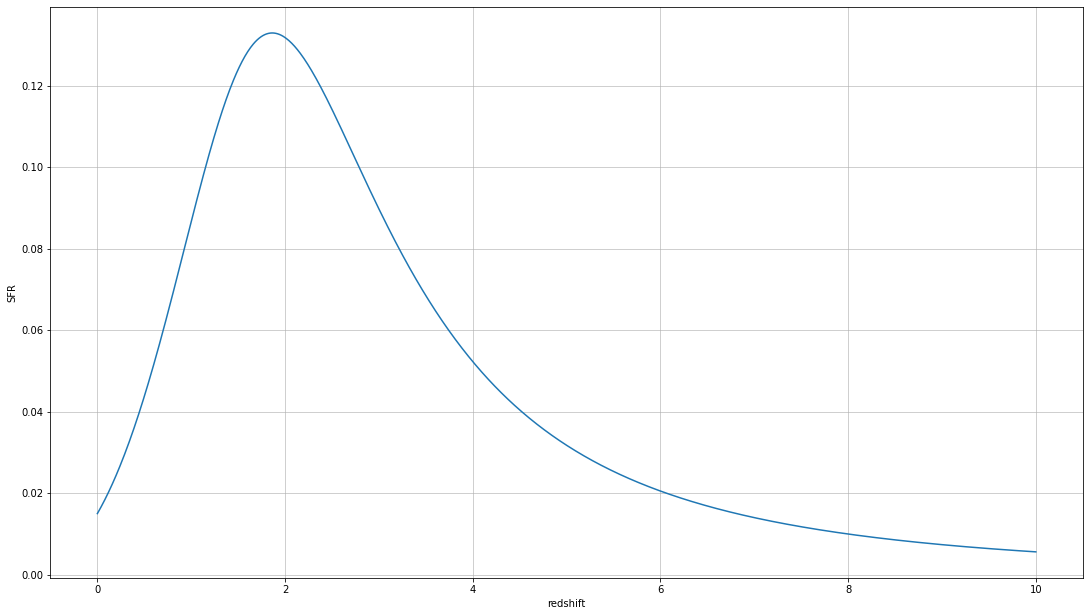

In [7]:
z_for_plot=np.linspace(0,10,1000)
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.rcParams.update({'font.size': 25})
ax.set_xlabel('redshift')
ax.set_ylabel('SFR')
ax.plot(z_for_plot,psi(z_for_plot),label='Mandau SFR')
#plt.yscale('log')
#plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)
#plt.savefig('star_formation_rate.png')

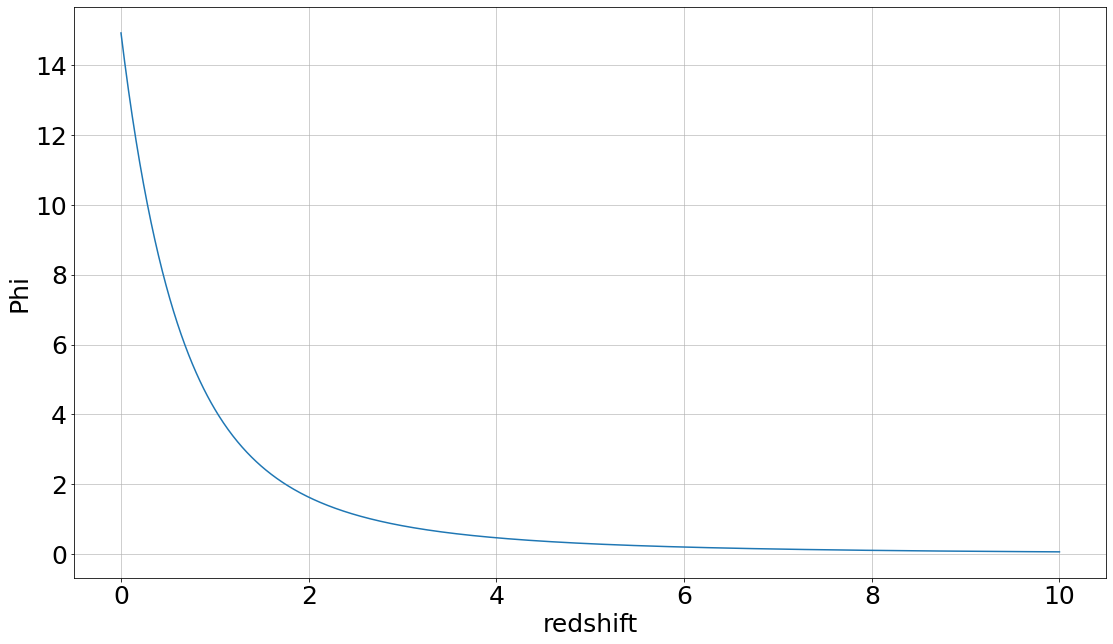

In [8]:
z_for_plot=np.linspace(0,10,1000)
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('redshift')
ax.set_ylabel('Phi')
ax.plot(z_for_plot,phi(z_for_plot),label='Mandau SFR')
#plt.yscale('log')
#plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)

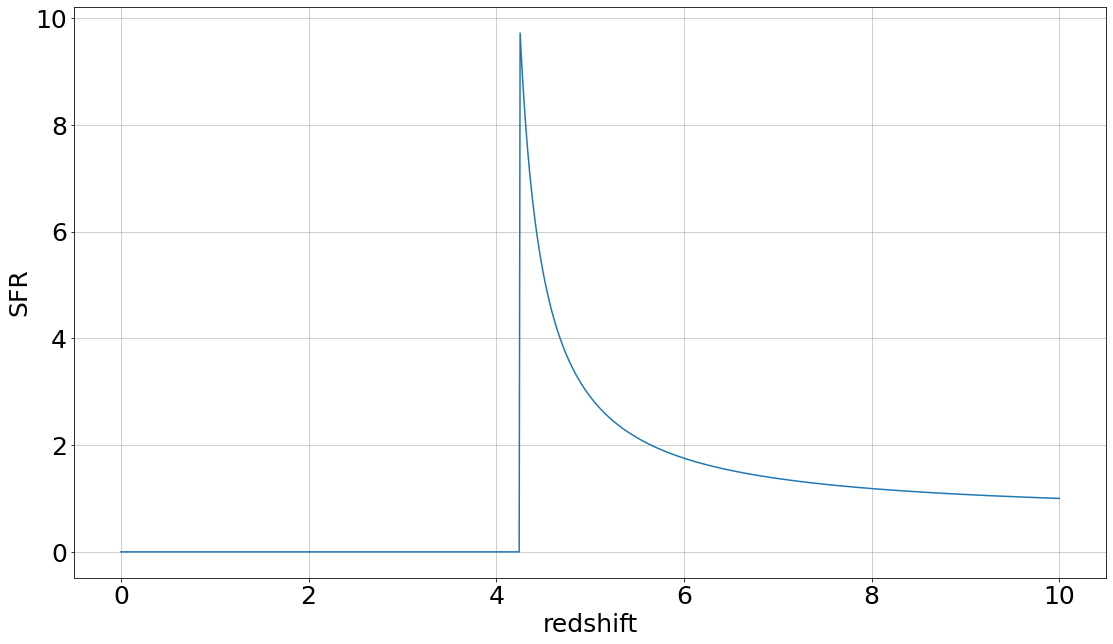

In [9]:
z_for_plot=np.linspace(0,10,1000)
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('redshift')
ax.set_ylabel('SFR')
ax.plot(z_for_plot,inversetimediff(z_for_plot,4,0.1),label='Mandau SFR')
#plt.yscale('log')
#plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)

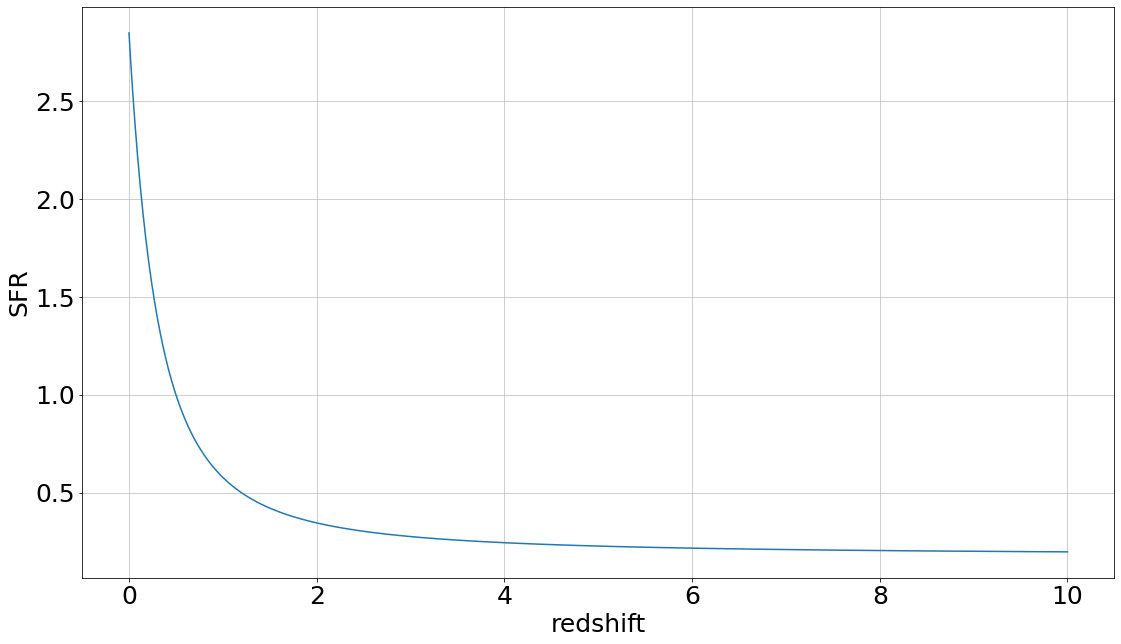

In [10]:
z_for_plot=np.linspace(0,10,1000)
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('redshift')
ax.set_ylabel('SFR')
ax.plot(z_for_plot,decay(z_for_plot,0.5,5),label='Mandau SFR')
#plt.yscale('log')
#plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)

In [11]:
z_min=0
z_max=z_min+100
tpar=5
#--------Normalization (z=0,N*R(z=0)=25)----------------------------
Normaliz=50/(quad(integrand_marr,z_min,z_max,args=(z_min,tpar))[0]/tpar)
#print(Normaliz)
#-------------loop for the plot------------------------------------
z_plot_max=3.5
ZZ=np.linspace(z_min,z_plot_max,150)
ratetoplot=np.zeros(len(ZZ))
for i in range(len(ZZ)):
    #Normaliz=25/quad(integrand,z_min,z_max,args=(z_min,tstart))[0]
    ratetoplot[i]=Normaliz*(quad(integrand_marr,ZZ[i],ZZ[i]+100,args=(ZZ[i],tpar))[0]/tpar)

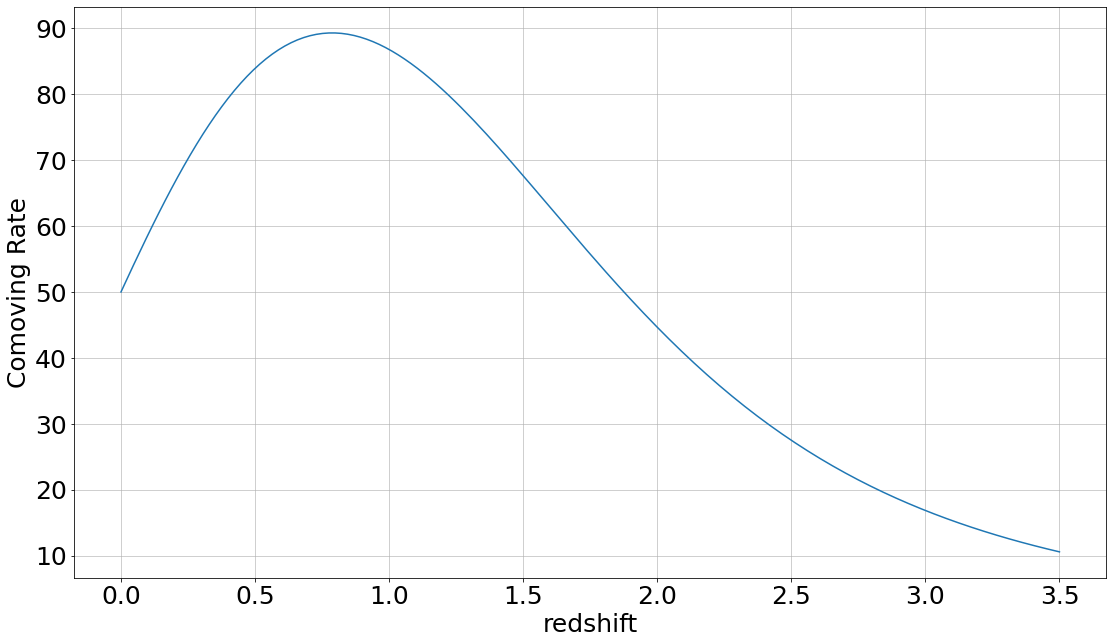

In [12]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('redshift')
ax.set_ylabel('Comoving Rate')
#test=ratetoplot
#test01=ratetoplot01
ax.plot(ZZ,ratetoplot,label='Comoving Rate')
#plt.yscale('log')
#plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)
plt.savefig('marra_comoving_rate.png')

In [13]:
#arrtest=np.linspace(0,10,10)
#mydiffvol=np.zeros(len(arrtest))
#for i in range(len(mydiffvol)):
#    mydiffvol[i]=DvolDz(arrtest[i])
#astrodiffvol=cosmoglob.differential_comoving_volume(arrtest).value
#residuals=mydiffvol-astrodiffvol
#print(residuals)
np.savetxt('comovingrate.txt',ratetoplot)
np.savetxt('zz_comovingrate.txt',ZZ)

In [ ]:
#-------------------Normalisation for the total rate---------------


In [36]:
z_min=0
tpar=5
#-------------loop for the plot------------------------------------
z_plot_max=3
norm=50/totalrate(0.220,5)#just from the plot on the paper
ZZ=np.linspace(z_min,z_plot_max,100)
totalratetoplot=np.zeros(len(ZZ))
for i in range(len(ZZ)):
    totalratetoplot[i]=norm*totalrate(ZZ[i],tpar)

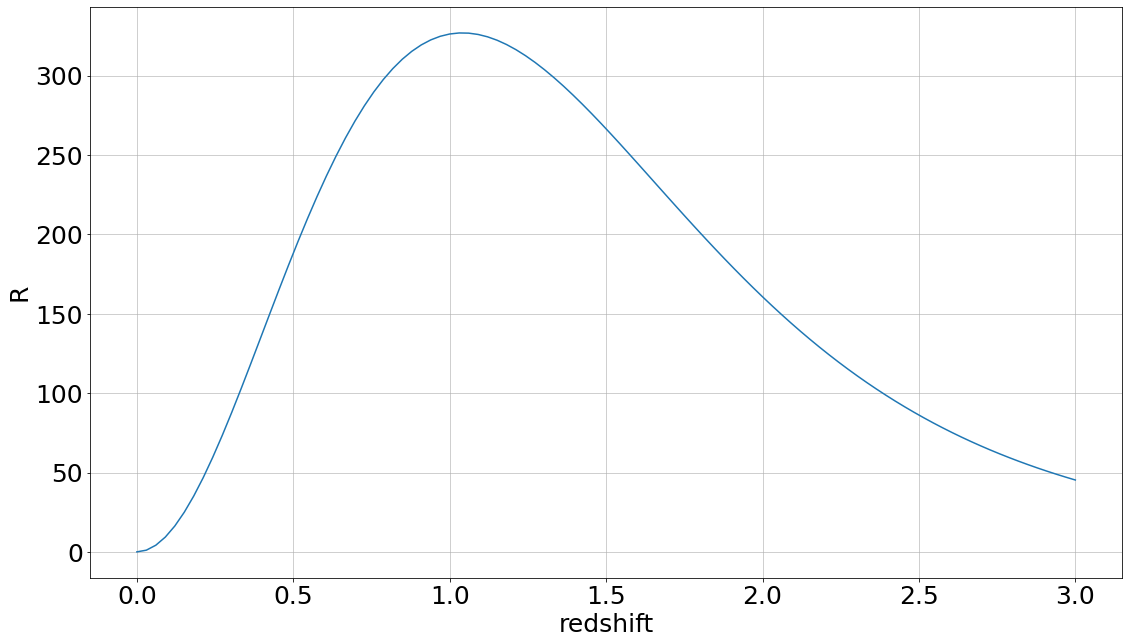

In [39]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('redshift')
ax.set_ylabel('R')
#test=ratetoplot
#test01=ratetoplot01
ax.plot(ZZ,totalratetoplot,label='Rate')
#plt.yscale('log')
#plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)
plt.savefig('marra_rate.png')

In [ ]:
peack=np.argmax(totalratetoplot)
res=ZZ[peack]
print(res)

In [ ]:
#----------------x-Check with Mathematica------------------------
near=np.linspace(0,20,100)
pyres=cosmofast.H(near).value
hmath=np.array([70.,77.3499,86.5951,97.5695,110.086,123.972,139.078,155.282,172.486,190.61,209.588,229.368,249.903,271.157,293.098,315.697,338.93,362.775,387.213,412.228,437.802,463.922,490.576,517.75,545.434,573.616,602.289,631.442,661.066,691.155,721.699,752.693,784.129,816.,848.3,881.024,914.165,947.719,981.68,1016.04,1050.8,1085.95,1121.49,1157.42,1193.72,1230.4,1267.45,1304.87,1342.65,1380.79,1419.29,1458.15,1497.35,1536.9,1576.8,1617.04,1657.61,1698.52,1739.77,1781.34,1823.24,1865.47,1908.01,1950.88,1994.07,2037.57,2081.38,2125.5,2169.94,2214.68,2259.72,2305.06,2350.71,2396.65,2442.89,2489.42,2536.25,2583.37,2630.77,2678.46,2726.44,2774.7,2823.25,2872.07,2921.17,2970.55,3020.21,3070.14,3120.34,3170.81,3221.55,3272.56,3323.84,3375.38,3427.19,3479.26,3531.59,3584.18,3637.03,3690.14])
to_plot=(1-(pyres/hmath))
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('redshift')
ax.set_ylabel('Residuals')
ax.plot(near,to_plot,label='Residuals')
#plt.yscale('log')
#plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)
#plt.savefig('HofzResiduals.pdf')

In [ ]:
#############################################################################################
###############--------DS-spatial-coordinates-###############################################
#############################################################################################

#Restrict the angular coordinate to be those of the flagship
phi_min=df.ra_gal.min()#*np.pi/180
phi_max=df.ra_gal.max()#*np.pi/180
theta_min=df.dec_gal.min()#*np.pi/180
theta_max=df.dec_gal.max()#*np.pi/180
#Restrict to the right redshift interval
z_min=df.true_redshift_gal.min()
z_max=df.true_redshift_gal.max()
print('phi_min={}, phi_max={}, \ntheta_min={}, theta_max{}, \nz_min{}, z_max={}'
      .format(phi_min,phi_max,theta_min,theta_max,z_min,z_max))
#ds_phi=np.random.uniform(0,phi_lim,500000)
ang_epsilon=0.1
red_epsilon=0.01
temp_phi=np.random.uniform(phi_min,phi_max,100000)#degrees
temp_theta=np.random.uniform(theta_min,theta_max,100000)#degrees
temp_z_values=np.loadtxt('redshift_MC.txt')
two_point_radii=np.loadtxt('two_point_radii.txt')
two_point_radii_cutted=np.loadtxt('two_point_radii_cutted.txt')

In [ ]:
#----------------MC-rejection-with-CDF RedShift--------------------
redo=0
if redo==1:
    tpar=5
    #--------Normalization (z=0,N*R(z=0)=50)----------------------------
    Normaliz=50/(quad(integrand_marr,0,100,args=(0,tpar))[0]/tpar)
    #print(Normaliz)
    #-------------loop------------------------------------
    ZZ=np.linspace(z_min,z_max,500000)
    temprate=np.zeros(len(ZZ))
    start_time = time.time()
    with Pool(35) as p:
        temprate=p.map(Multy_Marra, ZZ)
    print("--- %s seconds ---" % (time.time() - start_time))
    #target function
    rate_dist=interpolate.interp1d(ZZ,temprate)
    ToSave=return_samples(rate_dist,z_min,z_max,500000)
    np.savetxt('redshift_MC.txt',ToSave)


In [ ]:
x = np.linspace(z_min,z_max,1000000)
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')
ax.set_ylabel('probability density')
ax.plot(x,rate_dist(x)/np.sum(rate_dist(x)*(x[1]-x[0])) )
#ax.plot(x,target_dist(x)/norm ) #slow
ax.hist(temp_z_values,bins='auto',density=True,range=(x.min(),x.max()))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Redshift')
plt.ylabel('Frequency')
plt.yscale('log')
plt.xscale('log')
plt.title('z distribution')
plt.show() 

In [ ]:
one_phi=np.random.choice(temp_phi)
one_theta=np.random.choice(temp_theta)
one_zeta=np.random.choice(temp_z_values)
df_candidates=df
print('phi={}, theta={}, z={}'.format(one_phi,one_theta,one_zeta))

In [ ]:

#Create a list of possible host
k=1
#print(df_candidates.empty)
while True:
    df_candidates=df[(df['ra_gal']>one_phi-k*ang_epsilon) & (df['ra_gal']<one_phi+k*ang_epsilon)]
    df_candidates=df_candidates[(df_candidates['dec_gal']>one_theta-k*ang_epsilon) & (df_candidates['dec_gal']<one_theta+k*ang_epsilon)]
    df_candidates=df_candidates[(df_candidates['true_redshift_gal']>one_zeta-k*red_epsilon) & (df_candidates['true_redshift_gal']<one_zeta+k*red_epsilon)]
    if df_candidates.empty:
        print('possible host dataframe is empty, I will increase the tollerance')
        k=k+1 
    if (df_candidates.empty==False):
        break
#Raul: given a point in space, find nearest N host given the list
df_candidates=df_candidates.reset_index(drop=True)
if (df_candidates.shape[0]==1):
    unique_host=df_candidates.head(1)

if (df_candidates.shape[0]>1):
    parameterdist=np.zeros(df_candidates.shape[0])
    for index, row in df_candidates.iterrows():
        parameterdist[index]=np.sqrt((row['dec_gal']-one_theta)**2+(row['ra_gal']-one_phi)**2+(row['true_redshift_gal']-one_zeta)**2)
    df_candidates['parameterdist']=parameterdist
    df_candidates=df_candidates.sort_values(["parameterdist"], ascending=True) 
    unique_host=df_candidates.head(1)
#Now, for each value of angles and z, we select a single host


In [ ]:
x_host=unique_host['x_gal'].values[0]#/h
y_host=unique_host['y_gal'].values[0]#/h
z_host=unique_host['z_gal'].values[0]#/h
pp=np.random.uniform(0,2*np.pi)
costt=np.random.uniform(-1,1)
tt=np.arccos(costt)
distcut=0.1*h
while True:
    r=np.random.choice(two_point_radii)
    if(r>=distcut):
        break
xx=r*np.sin(tt)*np.cos(pp)
yy=r*np.sin(tt)*np.sin(pp)
zz=r*np.sin(tt)*np.cos(pp)
xDS=x_host+xx
yDS=y_host+yy
zDS=z_host+zz

In [ ]:
print(xDS,yDS,zDS)

In [ ]:
unique_host

In [ ]:
#--Absolute number of DS per year use the total rate (dN/dzdt) for a single year--------------#
#--integrate the rate in a given z range and then iterate the creation rotune that many times-#


In [ ]:
#-------------A more fine evaluation for interpolation-------------------------
z_plot_max=3
tpar=5
norm=50/totalrate(0.220,5)#just from the plot on the paper
ZZ=np.linspace(df.true_redshift_gal.min(),df.true_redshift_gal.max(),1000)
totalratetoplot=np.zeros(len(ZZ))
for i in range(len(ZZ)):
    totalratetoplot[i]=norm*totalrate(ZZ[i],tpar)


In [ ]:
rate_interpol=interpolate.interp1d(ZZ,totalratetoplot)

In [ ]:
tempx=np.linspace(ZZ.min(),ZZ.max(),1500)
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('redshift')
ax.set_ylabel('RateGW')
#test=ratetoplot
#test01=ratetoplot01
#ax.plot(ZZ,totalratetoplot,label='RateGW',color='k')
#ax.scatter(ZZ,rate_interpol(ZZ),color='g',s=50,marker='+')
ax.plot(tempx,rate_interpol(tempx),label='RateGW',color='k')
#plt.yscale('log')
#plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)

In [ ]:
nbins_rate=151
step_rate=(df.true_redshift_gal.max()-df.true_redshift_gal.min())/nbins_rate
arr_of_int_lim=np.linspace(df.true_redshift_gal.min(),df.true_redshift_gal.max(),nbins_rate)


In [ ]:
Numb_DS_of_z=np.zeros(len(arr_of_int_lim)-1)
for i in range(nbins_rate-1):
    #volmult=DvolDz(arr_of_int_lim[i+1])-DvolDz(arr_of_int_lim[i])
    Numb_DS_of_z[i]=quad(rate_interpol,arr_of_int_lim[i],arr_of_int_lim[i+1])[0]#*volmult

In [ ]:
#-----now assign an integer value, remember to sometimes put more ds so use round
radphimin=deg_to_rad(phi_min)
radphimax=deg_to_rad(phi_max)
radthetamin=deg_to_rad(theta_min)
radthetamax=deg_to_rad(theta_max)
angular_part=(radphimax-radphimin)*(-(np.cos(radthetamax)-np.cos(radthetamin)))
#print(angular_part)
Numb_DS_of_z=Numb_DS_of_z*angular_part*1000#this is just a factor to create a more populated catalogue
Numb_DS_of_z_int=np.around(Numb_DS_of_z)


In [ ]:
#np.savetxt('arr_of_int_lim.txt',arr_of_int_lim)
#np.savetxt('Numb_DS_of_z_int.txt',Numb_DS_of_z_int)

In [5]:
dat = Table.read('EVA01.fits', format='fits')
dscat = dat.to_pandas()#all good, is an only text fits
print(dscat.columns)
print(dscat.shape)

Index(['Host_x', 'Host_y', 'Host_z', 'Host_redshift', 'DS_x', 'DS_y', 'DS_z',
       'DS_redshift', 'cos_orbital_incl', 'M1', 'M2', 'q'],
      dtype='object')
(515652, 12)


In [15]:
ratex=np.loadtxt('/home/rciancarella/DarkSirensStat/DSCatalogueCreator/zz_comovingrate.txt')
ratey=np.loadtxt('/home/rciancarella/DarkSirensStat/DSCatalogueCreator/comovingrate.txt')
myrate=interpolate.interp1d(ratex,ratey,kind='cubic',fill_value='extrapolate')

In [16]:
z=np.linspace(0,3,100)
myrate(z)

array([50.        , 52.65720582, 55.27756632, 57.85048683, 60.36590531,
       62.81434723, 65.18697868, 67.4756426 , 69.67288826, 71.77199251,
       73.76696545, 75.65255081, 77.4242227 , 79.07817136, 80.61128256,
       82.02111645, 83.30588297, 84.46440942, 85.49610924, 86.40095187,
       87.17942747, 87.83251163, 88.3616329 , 88.76863974, 89.05576548,
       89.22559635, 89.28104157, 89.22530163, 89.06183858, 88.79434863,
       88.42673506, 87.96308114, 87.40762543, 86.76473809, 86.0388971 ,
       85.23466591, 84.35667225, 83.40958733, 82.39810577, 81.32692665,
       80.20073497, 79.02418404, 77.80187886, 76.53835969, 75.23808696,
       73.90542723, 72.5446396 , 71.15986291, 69.75510489, 68.33423191,
       66.90095913, 65.4588427 , 64.01127347, 62.56147077, 61.11247756,
       59.66715804, 58.2281955 , 56.79809057, 55.37916204, 53.97354853,
       52.58321018, 51.2099316 , 49.85532677, 48.52084366, 47.20776904,
       45.91723518, 44.65022669, 43.40758689, 42.19002513, 40.99